# Holt Winters' Exponential Smoothing

The Holt Winters' model allows us to use the exponential smoothing on the linear, trend, and seasonal components; Another property of HWES' models are that could be used for non-stationary data. More info: [https://otexts.com/fpp3/holt-winters.html](https://otexts.com/fpp3/holt-winters.html)

- **Author:** BrenoAV
- **Date:** 10-23-2023

# IMPORTING LIBRARIES

In [1]:
from datetime import datetime
from typing import Optional
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, HoltWintersResults
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
plt.style.use("ggplot")

# Load train and test datasets

The dataset could be downloaded on Kaggle manually (Read the [README.md](../README.md))

In [3]:
train_raw_df = pd.read_csv("/home/brenoav/Datasets/TimeSeries/DailyClimate/DailyDelhiClimateTrain.csv")
test_raw_df = pd.read_csv("/home/brenoav/Datasets/TimeSeries/DailyClimate/DailyDelhiClimateTest.csv")

## Checking for NULL/NA values

In [4]:
train_raw_df.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [5]:
train_raw_df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [6]:
test_raw_df.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [7]:
test_raw_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


There are no NULL or NA values. Great 🙂 But there's a conflict with the last date of the train dataset and the beginner of the test dataset. My hypothesis is that the value downfalls of the first dataset is too abrupt... Then I'll consider that is not correct and keep the first data of the test dataset.

In [8]:
train_raw_df.drop(train_raw_df.tail(1).index, inplace=True)

## Transforming date column 'object' &rarr; 'datetime'

In [9]:
train_raw_df["date"] = pd.to_datetime(train_raw_df["date"], yearfirst=True)
train_raw_df.set_index("date", inplace=True, drop=True)
test_raw_df["date"] = pd.to_datetime(test_raw_df["date"], yearfirst=True)
test_raw_df.set_index("date", inplace=True, drop=True)

In [10]:
# The dataset frequency is daily
train_raw_df = train_raw_df.asfreq("D")
test_raw_df = test_raw_df.asfreq("D")

# DATA PLOT

In [11]:
def plot_time_series(x: NDArray, y: NDArray, title: str, label: Optional[str], color: str) -> None:
    plt.plot(x, y, label=label, color=color)
    plt.title(title)
    plt.xticks(rotation=45)
    if label:
        plt.legend()

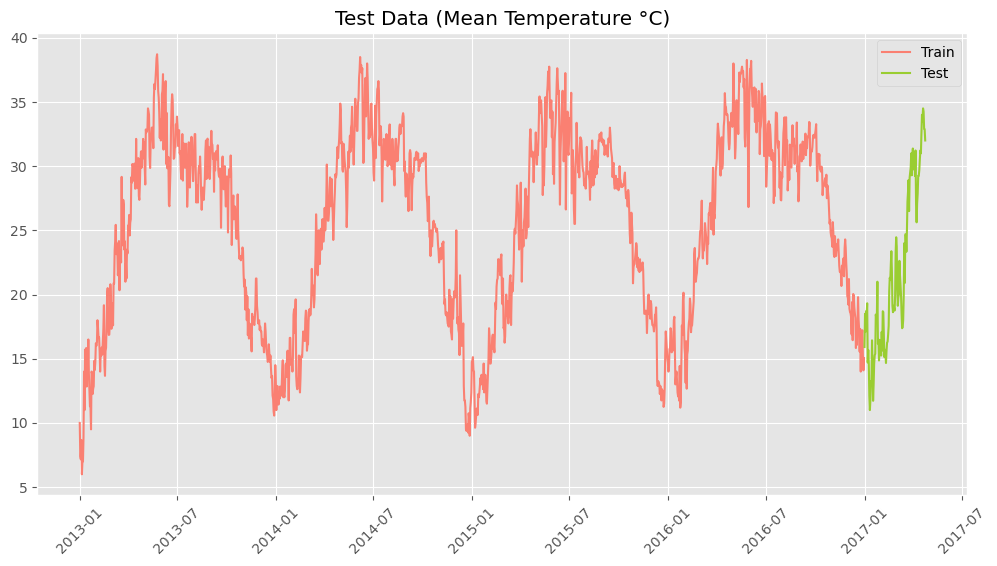

In [12]:
plt.figure(figsize=(12, 6))
plot_time_series(train_raw_df.index, train_raw_df["meantemp"].values, 
                 title="Train Data (Mean Temperature °C)", 
                 label="Train", 
                 color="salmon")
plot_time_series(test_raw_df.index, test_raw_df["meantemp"].values, 
                 title="Test Data (Mean Temperature °C)", 
                 label="Test", 
                 color="yellowgreen")
plt.show()

# TIME SERIES DECOMPOSITION

## Moving average approach

- Additive:

$$ Y_t = T_t + S_t + e_t $$

- Multiplicative

$$ Y_t = T_t \times S_t \times e_t $$

In [13]:
decompose_result = seasonal_decompose(x=train_raw_df["meantemp"], model="additive")

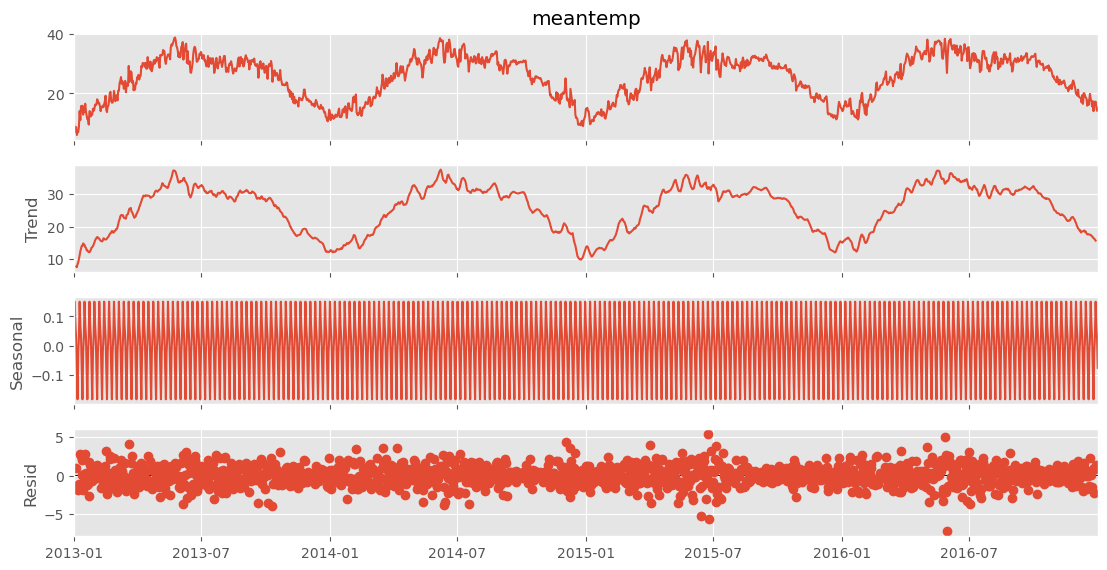

In [14]:
fig = decompose_result.plot()
fig.set_size_inches(12, 6)
plt.show()

## Seasonal and Trend decomposition using Loess (STL)

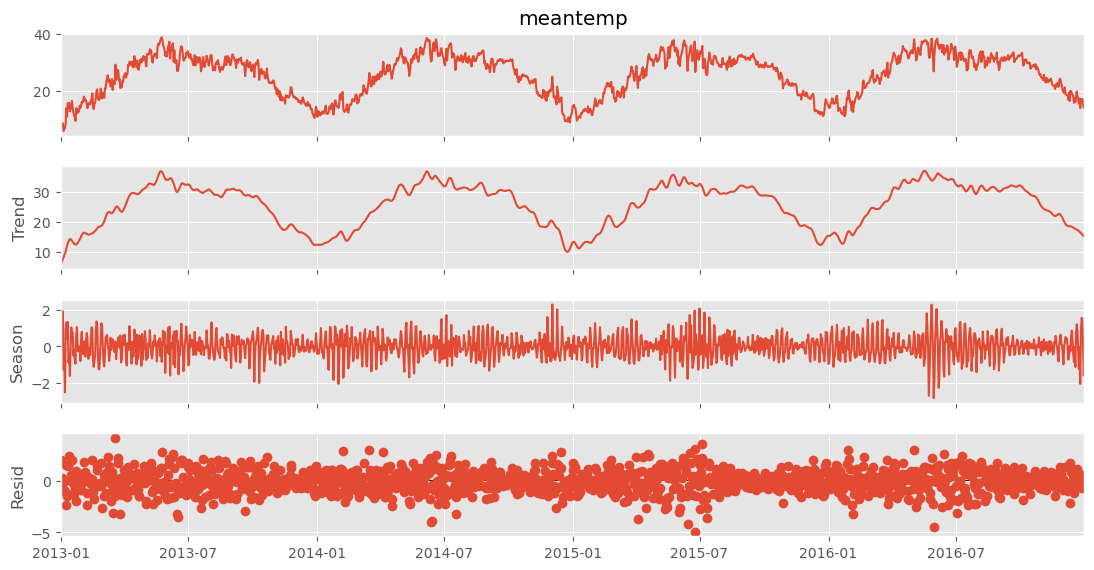

In [15]:
decompose_result = STL(train_raw_df["meantemp"]).fit()
fig = decompose_result.plot()
fig.set_size_inches(12, 6)
plt.show()

# HOLT-WINTERS - LINEAR

The idea with the Holt Winters' model is to use the exponential to decrease the importance of long time ago values and give more importance to short time date. The explanation of the model could be found at the link at the beginning of the notebook.

In [16]:
def forecast_model(train_df: pd.DataFrame, 
                   test_df: pd.DataFrame, 
                   model: HoltWintersResults, 
                   forecast: int, 
                   mode: Optional[str] = None) -> pd.Series:
    y_pred = model.forecast(forecast)
    train_df["meantemp"].plot(legend=True, label="Train", figsize=(12, 6))
    test_df["meantemp"].plot(legend=True, label="Test", figsize=(12, 6))
    if mode:
        title = f"Train vs Test vs Pred ({mode})"
    else:
        title = "Train vs Test vs Pred"
    y_pred.plot(legend=True, label="Pred", figsize=(12, 6), ylabel="temperature °C", title=title)
    return y_pred

def show_metrics(y_test:NDArray, y_pred:NDArray):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"MAE = {mae:.4f}\nMSE = {mse:.4f}\nRMSE = {rmse:.4f}")

In [17]:
train_df = train_raw_df.copy()
test_df = test_raw_df.copy()

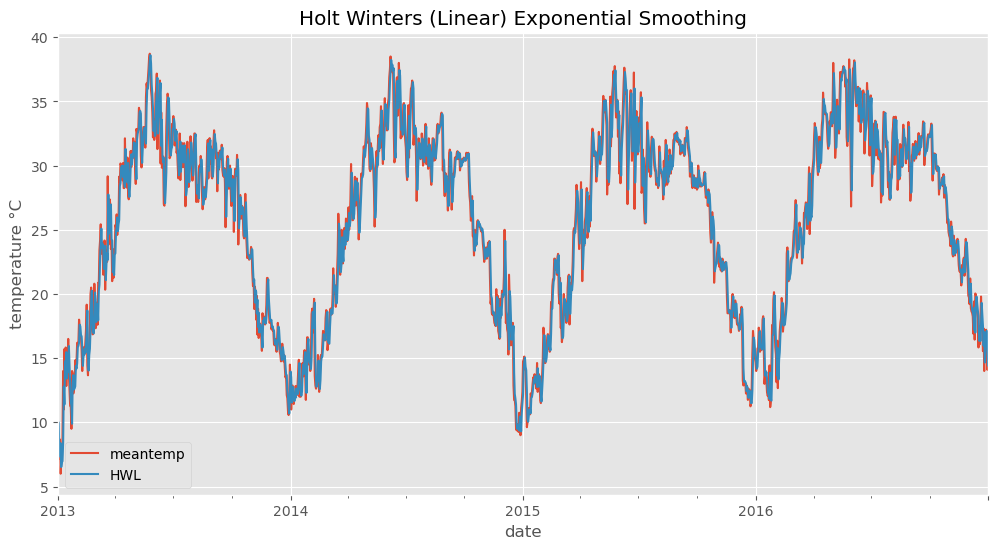

In [18]:
simple_model = SimpleExpSmoothing(endog=train_raw_df["meantemp"]).fit()
train_df["HWL"] = simple_model.fittedvalues
train_df[["meantemp", "HWL"]].plot(title="Holt Winters (Linear) Exponential Smoothing", figsize=(12, 6), ylabel="temperature °C")
plt.show()

## Forecast Test

It's great, but we can't forecast because this uses only the past value to predict one value ahead, i. e., we just have the option to use the same value until the end.

MAE = 7.1419
MSE = 86.2733
RMSE = 9.2883


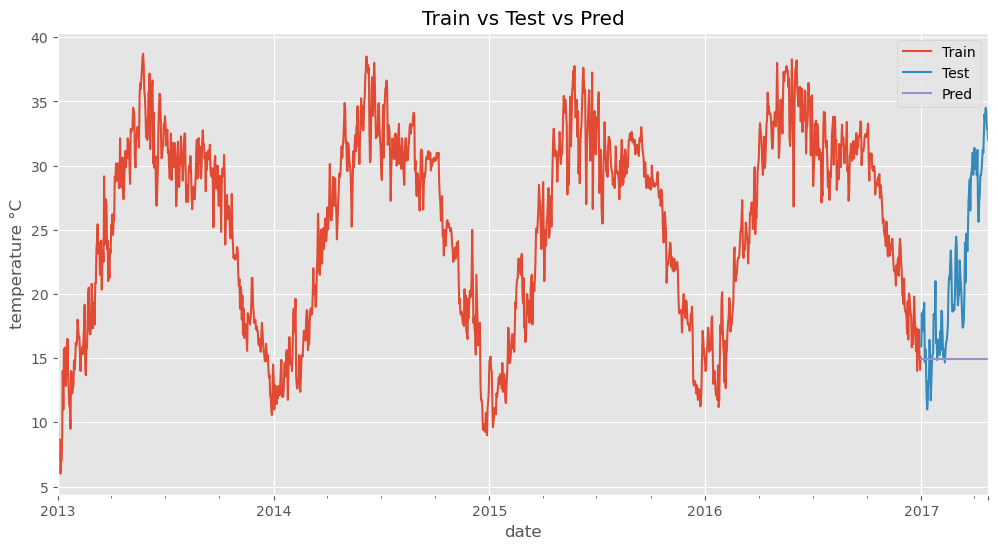

In [19]:
y_pred = forecast_model(train_df=train_df, test_df=test_df, model=simple_model, forecast=len(test_df))
show_metrics(y_test=test_df["meantemp"].values, y_pred=y_pred.values)    

Not good at all 😕

# HOLT-WINTERS - LINEAR AND TREND

/home/brenoav/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


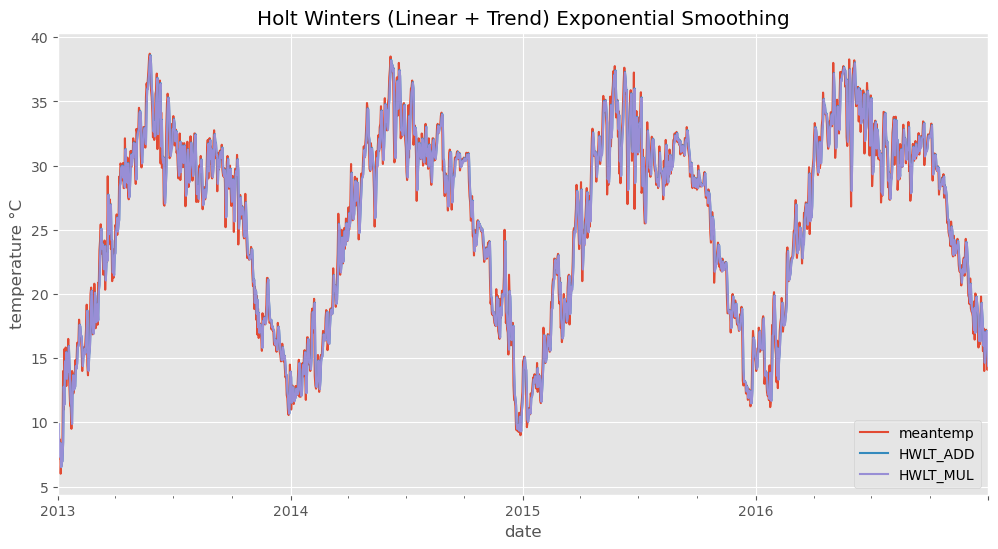

In [20]:
model_lt_add = ExponentialSmoothing(endog=train_raw_df["meantemp"], trend="add").fit()
train_df["HWLT_ADD"] = model_lt_add.fittedvalues
model_lt_mul = ExponentialSmoothing(endog=train_raw_df["meantemp"], trend="mul").fit()
train_df["HWLT_MUL"] = model_lt_mul.fittedvalues
train_df[["meantemp", "HWLT_ADD", "HWLT_MUL"]].plot(title="Holt Winters (Linear + Trend) Exponential Smoothing", figsize=(12, 6), ylabel="temperature °C")
plt.show()

## Forecast Test

--- Model Additive ---
MAE = 6.9391
MSE = 81.9780
RMSE = 9.0542


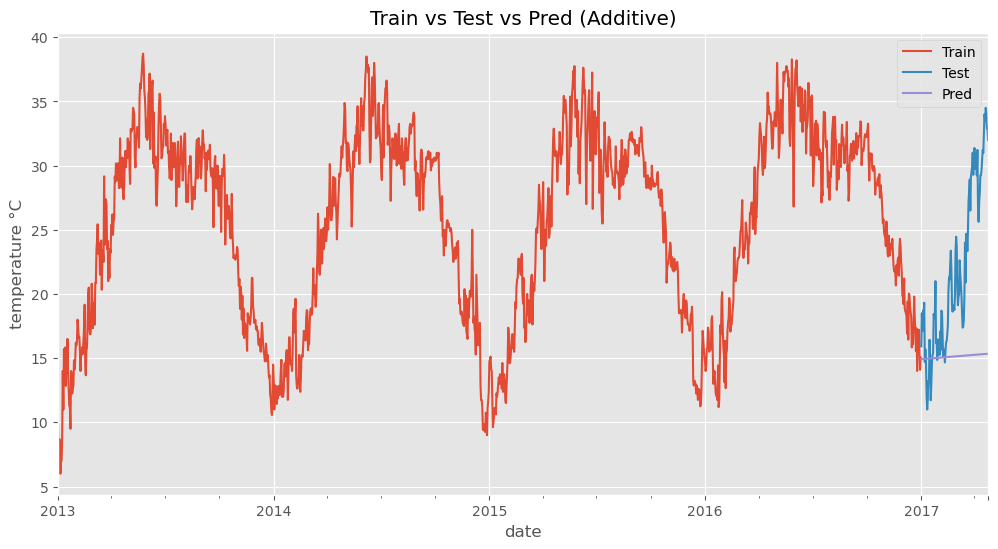

In [21]:
y_pred_add = forecast_model(train_df=train_df, 
                            test_df=test_df, 
                            model=model_lt_add, 
                            forecast=len(test_df),
                            mode="Additive")
print("--- Model Additive ---")
show_metrics(y_test=test_df["meantemp"].values, y_pred=y_pred_add.values)

--- Model Multiplicative ---
MAE = 8.0040
MSE = 105.4560
RMSE = 10.2692


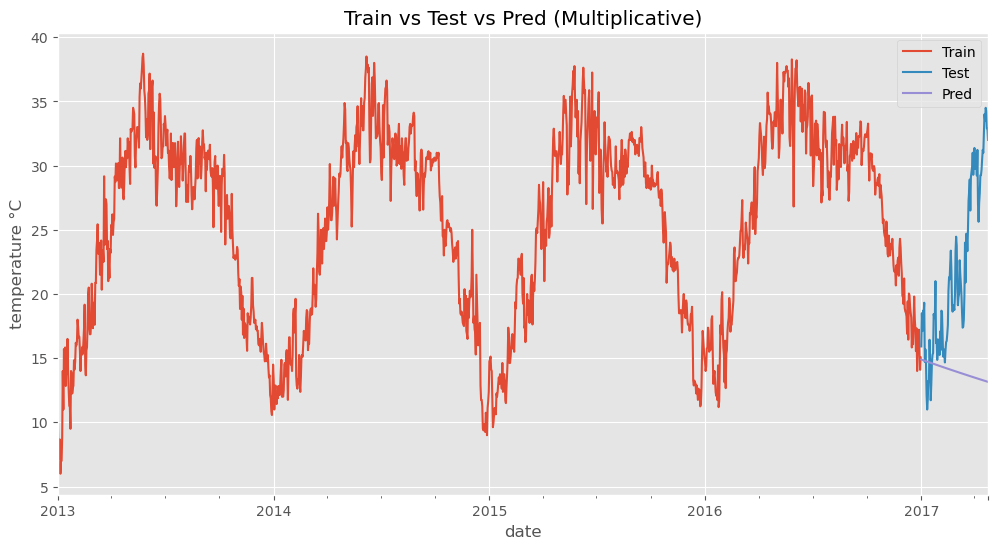

In [22]:
y_pred_mul = forecast_model(train_df=train_df, 
                            test_df=test_df, 
                            model=model_lt_mul, 
                            forecast=len(test_df),
                            mode="Multiplicative")
print("--- Model Multiplicative ---")
show_metrics(y_test=test_df["meantemp"].values, y_pred=y_pred_mul.values)

As expected, is a linear straight line! But not so good because the data has seasonality.

# HW Triple

/home/brenoav/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/brenoav/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


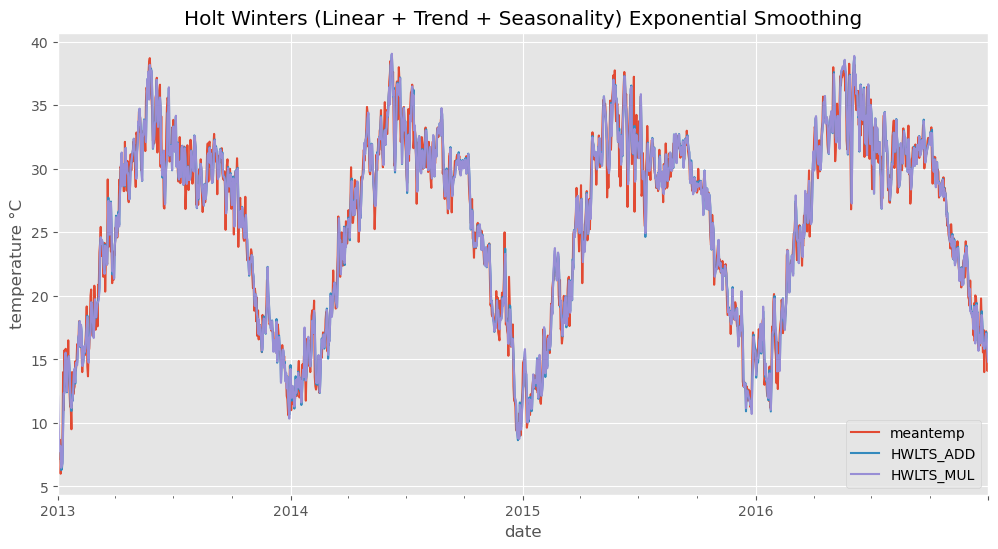

In [23]:
model_lts_add = ExponentialSmoothing(endog=train_df["meantemp"], 
                                             trend="add", 
                                             seasonal="add", 
                                             seasonal_periods=365).fit()
train_df["HWLTS_ADD"] = model_lts_add.fittedvalues
model_lts_mul = ExponentialSmoothing(endog=train_df["meantemp"], 
                                             trend="mul", 
                                             seasonal="mul",
                                             seasonal_periods=365).fit()
train_df["HWLTS_MUL"] = model_lts_mul.fittedvalues
train_df[["meantemp", "HWLTS_ADD", "HWLTS_MUL"]].plot(title="Holt Winters (Linear + Trend + Seasonality) Exponential Smoothing", 
                                                      figsize=(12, 6), ylabel="temperature °C")
plt.show()

## Forecasting test

--- Model Additive ---
MAE = 2.2104
MSE = 7.0788
RMSE = 2.6606


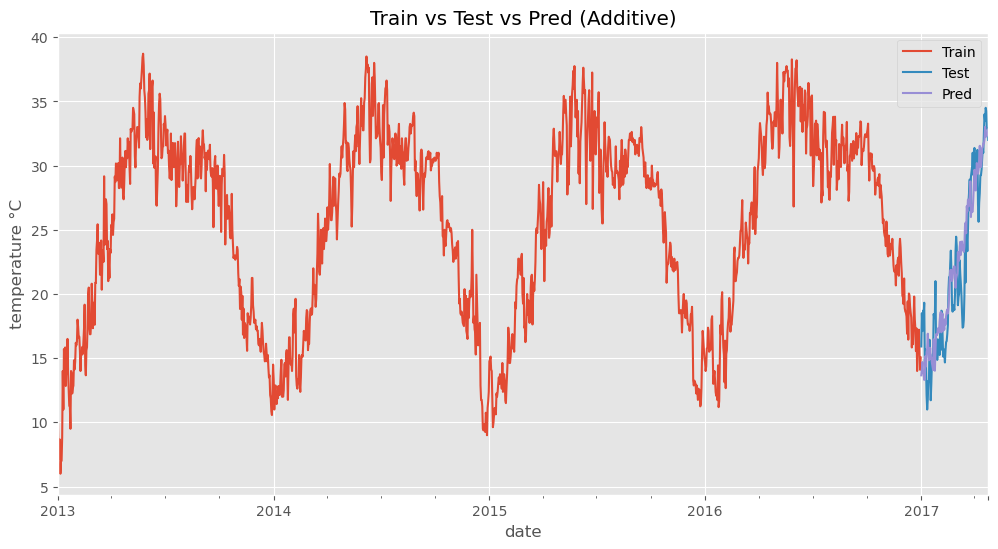

In [24]:
y_pred_add = forecast_model(train_df=train_df, 
                            test_df=test_df, 
                            model=model_lts_add, 
                            forecast=len(test_df),
                            mode="Additive")
print("--- Model Additive ---")
show_metrics(y_test=test_df["meantemp"].values, y_pred=y_pred_add.values)

--- Model Multiplicative ---
MAE = 5.6930
MSE = 40.3670
RMSE = 6.3535


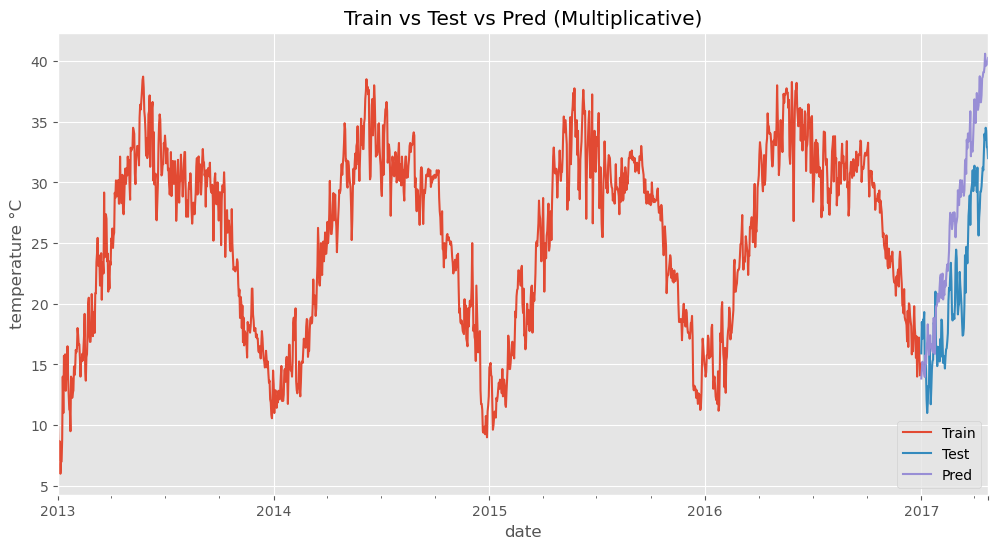

In [25]:
y_pred_mul = forecast_model(train_df=train_df, 
                            test_df=test_df, 
                            model=model_lts_mul, 
                            forecast=len(test_df),
                            mode="Multiplicative")
print("--- Model Multiplicative ---")
show_metrics(y_test=test_df["meantemp"].values, y_pred=y_pred_mul.values)

Seems a good model Holt-Winters with linear, trend, and seasonality exponential smoothing! 🥳

Let's zoom on the result of the last additive model and see more closely! 🧐

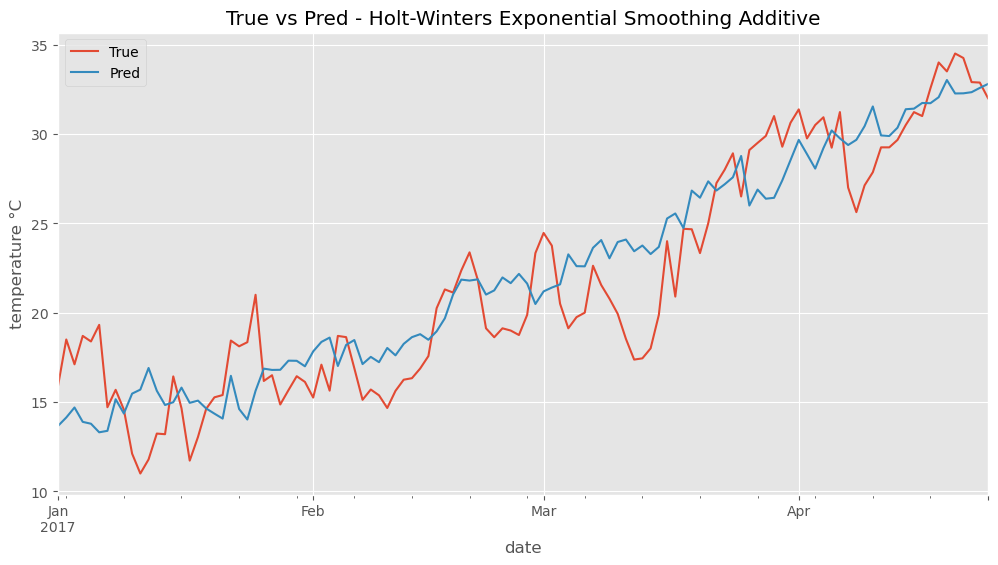

In [28]:
plt.figure(figsize=(12, 6))
test_df["meantemp"].plot(label="True")
y_pred_add.plot(label="Pred")
plt.title("True vs Pred - Holt-Winters Exponential Smoothing Additive")
plt.legend()
plt.ylabel("temperature °C")
plt.show()